In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

In [3]:
# Precomputed mean and STD of all the pixels in the MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3801

transforms_dataset = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray, ), (stddev_gray, ))])

train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms_dataset, 
    download=True
)

test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms_dataset
)

100%|██████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 2.94MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 120kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 7.68MB/s]


label: 4


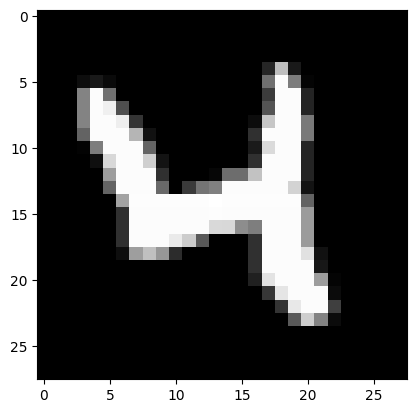

In [4]:
import matplotlib.pyplot as plt

random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
label = train_dataset[20][1]
plt.imshow(random_img.reshape(28,28), cmap='gray')
print(f"label: {label}")

In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

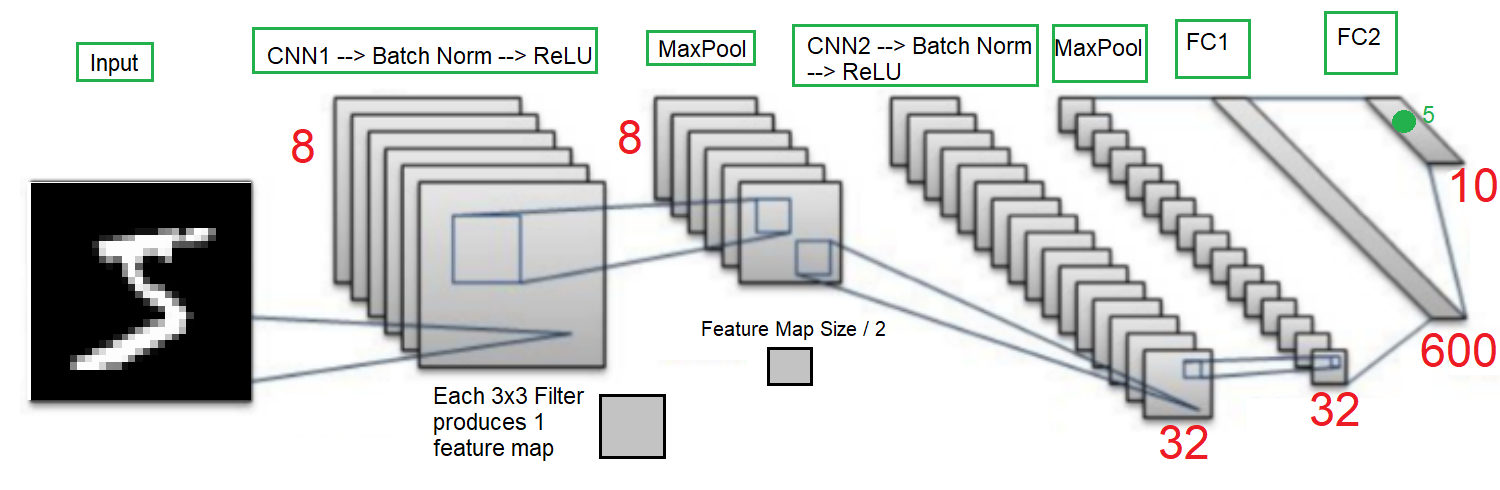

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Same Padding = input_size = output_size, = (filter_size - 1) / 2 = (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Output size of each of the 8 resultant feature maps = 
        # [(input_size - filter_size + 2(padding))/stride + 1] = (28 - 3 + 2(1))/1 + 1 = 28
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # Output size = 28/2 = 14

        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        # Output size of each of the 32 feature maps = [((14 - 5) + 2(2))/1 + 1] = 14
        self.batchnorm2 = nn.BatchNorm2d(32)

        # Flatten 32 feature maps (after maxpooling): 7 * 7 * 32 = 1568
        self.fc1 = nn.Linear(1568, 600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(600, 10)

    def forward(self, x):
        # First convulutional layer
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # Second convulutional layer
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # Flatten the 32 features from maxpooling
        out = out.view(-1, 1568)
        
        # Fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [7]:
model = CNN()
is_gpu = torch.backends.mps.is_available()

if is_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
# Understand what's happening
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_loader):
    if is_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()

    print("For one iteration:")
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")

    output = model(inputs)

    print(f"Output shape: {output.shape}")
    _, predicted = torch.max(output, 1)
    print(f"Predicted shape: {predicted.shape}")
    print("Predicted tensor:")
    print(predicted)

    correct += (predicted == labels).sum()
    break

For one iteration:
Input shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])
Output shape: torch.Size([100, 10])
Predicted shape: torch.Size([100])
Predicted tensor:
tensor([4, 0, 0, 0, 0, 7, 5, 3, 5, 3, 3, 0, 3, 0, 9, 0, 0, 3, 0, 0, 3, 0, 1, 3,
        9, 0, 6, 9, 0, 9, 0, 5, 5, 3, 0, 0, 6, 0, 4, 2, 0, 0, 3, 0, 5, 0, 3, 3,
        4, 0, 0, 3, 0, 0, 9, 0, 0, 3, 3, 5, 5, 1, 3, 0, 0, 0, 3, 3, 4, 0, 0, 4,
        3, 4, 4, 3, 1, 3, 3, 0, 3, 4, 0, 0, 0, 0, 9, 0, 3, 0, 4, 3, 0, 3, 5, 0,
        0, 0, 5, 0])


In [8]:
# Training the CNN
num_epochs = 25

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()  # Tell the model this is the training phase

    for i, (inputs, labels) in enumerate(train_loader):
        if is_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100 * correct / len(train_dataset))

    # Testing phase
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()  # Switch the model to evaluation mode

    for i, (inputs, labels) in enumerate(test_loader):
        if is_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

    test_loss.append(testing_loss / iterations)
    test_accuracy.append(100 * correct / len(test_dataset))

    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}'.format(
        epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]
    ))
print('Training Complete')

Epoch 1/25, Training Loss: 0.663, Training Accuracy: 81.468, Testing Loss: 0.088, Testing Accuracy: 97.300
Epoch 2/25, Training Loss: 0.199, Training Accuracy: 93.790, Testing Loss: 0.049, Testing Accuracy: 98.490
Epoch 3/25, Training Loss: 0.136, Training Accuracy: 95.942, Testing Loss: 0.049, Testing Accuracy: 98.470
Epoch 4/25, Training Loss: 0.111, Training Accuracy: 96.710, Testing Loss: 0.042, Testing Accuracy: 98.690
Epoch 5/25, Training Loss: 0.091, Training Accuracy: 97.350, Testing Loss: 0.046, Testing Accuracy: 98.660
Epoch 6/25, Training Loss: 0.081, Training Accuracy: 97.685, Testing Loss: 0.038, Testing Accuracy: 98.910
Epoch 7/25, Training Loss: 0.074, Training Accuracy: 97.908, Testing Loss: 0.037, Testing Accuracy: 98.930
Epoch 8/25, Training Loss: 0.075, Training Accuracy: 97.863, Testing Loss: 0.040, Testing Accuracy: 98.830
Epoch 9/25, Training Loss: 0.066, Training Accuracy: 98.123, Testing Loss: 0.050, Testing Accuracy: 98.840
Epoch 10/25, Training Loss: 0.065, Tr

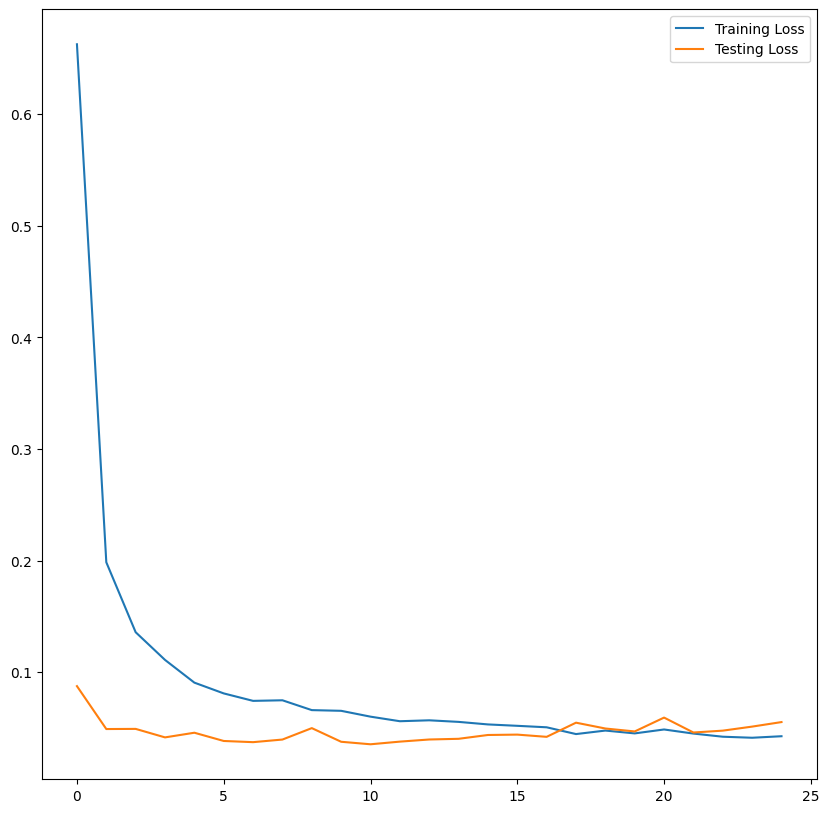

In [9]:
# Plotting the loss
f = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

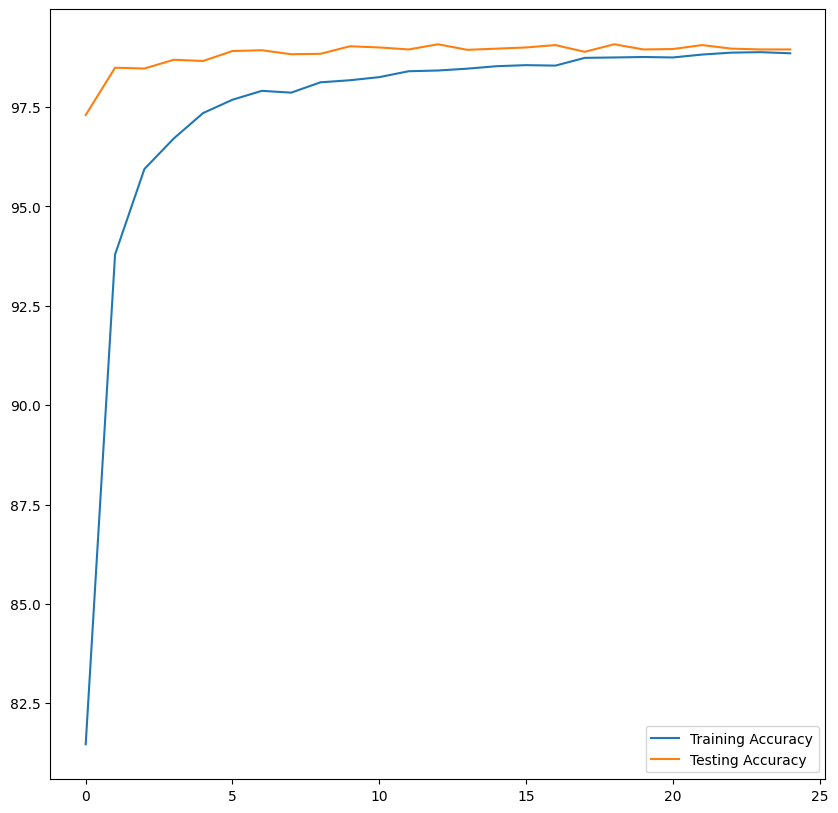

In [10]:
# Plotting the accuracy
f = plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [11]:
# Predictions
img = test_dataset[30][0].resize_((1, 1, 28, 28))
label = test_dataset[30][1]

model.eval()

if is_gpu:
    img = img.cuda()
    img = img.cuda()

outputs = model(img)
_, prediction = torch.max(outputs, 1)
print(f"Prediction is: {prediction.item()}")
print(f"Actual is: {label}")

Prediction is: 3
Actual is: 3


In [12]:
# Predict your own hand-written samples
import cv2
from PIL import Image

transforms_photo = transforms.Compose([
    transforms.Resize((28,28)), 
    transforms.ToTensor(), 
    transforms.Normalize((mean_gray, ), (stddev_gray, ))])

In [13]:
def predict(img_name, model):
    image = cv2.imread(img_name, 0)  # 0 for grayscale
    ret, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    img = 255 - thresholded  # Inverse black to white and vice-versa for our needs

    plt.imshow(img)
    plt.show()
    
    img = Image.fromarray(img)
    img = transforms_photo(img)
    img = img.view(1, 1, 28, 28)
    img = Variable(img)

    model.eval()

    if is_gpu:
        model = model.cuda()
        img = img.cuda()

    output = model(img)

    _, predicted = torch.max(output, 1)
    return predicted.item()

[[198 198 198 ... 177 176 176]
 [198 198 198 ... 177 176 176]
 [198 198 198 ... 176 176 176]
 ...
 [172 173 173 ... 153 152 153]
 [172 172 172 ... 153 152 153]
 [172 172 172 ... 153 152 153]]


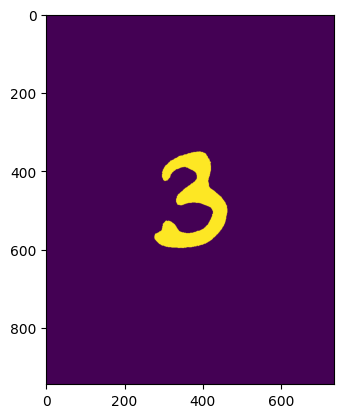

tensor([[-0.3228, -0.1126,  0.8134, -1.1985, -2.4761, -1.7567, -2.3066, -1.3438,
          0.2167, -0.0223]], grad_fn=<AddmmBackward0>)
Predicted label: 2


In [14]:
pred = predict('../mnist-cnn/3.jpg', model)
print(f"Predicted label: {pred}")